# classification

The purpose of this notebook is to assess different classification techniques with the credit card fraud data.

### import dependancies

In [1]:
from imblearn.over_sampling import SMOTE
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns
from time import perf_counter
import xgboost as xgb

### read in and manipulate data

In [2]:
cc = pd.read_parquet('../data/creditcard.parquet')

display(cc)

,time,amount,class,v1,v2,v3,v4,v5,v6,v7,...,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28
0,0,149.619995,False,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,0,2.690000,False,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,1,378.660004,False,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,1,123.500000,False,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,2,69.989998,False,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,...,0.803487,0.408542,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786,0.770000,False,-11.881118,10.071785,-9.834784,-2.066656,-5.364473,-2.606837,-4.918215,...,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731
284803,172787,24.790001,False,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,...,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527
284804,172788,67.879997,False,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,...,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561
284805,172788,10.000000,False,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,...,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533


### create any other objects that will be relevant for displaying data

In [3]:
# create empty data frame for model results
model_performance_results = pd.DataFrame(columns=['model_name', 'pr_auc', 'f1', 'roc_auc', 'R_squared',  'precision', 'recall', 'execution_time'])

### define functions

#### display_record_performance

I am going to add a function here to do all of my plotting and performanc metric calcuations, because repeatable code can be used to do it for each of the models I am using below.

In [4]:
def display_record_performance(model_performance_results, model_index, model, X_test, y_test, y_pred, y_pred_proba):
    # get the pr-auc score
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    model_performance_results.loc[model_index, 'pr_auc'] = pr_auc

    # get f1 statistic
    #f1 = classification_report(y_test, y_pred, output_dict=True)['f1-score']
    #model_performance_results.loc[model_index, 'f1'] = f1

    # get model roc_auc score
    roc_auc = roc_auc_score(y_test, y_pred)
    model_performance_results.loc[model_index, 'roc_auc'] = roc_auc

    # get moded R-squared
    R_squared = accuracy_score(y_test, y_pred)
    model_performance_results.loc[model_index, 'R_squared'] = R_squared

    # get model precision
    #precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
    #model_performance_results.loc[model_index, 'precision'] = precision

    # get model recall
    #recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    #model_performance_results.loc[model_index, 'recall'] = recall

    ## print model resutls
    display(model_performance_results)

    # Plot Precision-Recall curve
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    # plot the ROC curve
    y_pred_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()

    # visualize the confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix')
    plt.show()

    return model_performance_results

## logistic regression

### build model

In [5]:
# save the model name into the results data frame
model_index = 0

model_performance_results.loc[model_index, 'model_name'] = 'logistic regression'

start_time = perf_counter()

X = cc.drop('class', axis=1)  # Features
y = cc['class']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

# note the number of iterations needed to achieve convergence
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

end_time = perf_counter()

# calculate the exectution time and save to the results data frame
execution_time = end_time - start_time
model_performance_results.loc[model_index, 'execution_time'] = execution_time

print(f"Execution time: {end_time - start_time} seconds")

Execution time: 62.182698699994944 seconds


### display model metrics

,model_name,pr_auc,f1,roc_auc,R_squared,precision,recall,execution_time
0,logistic regression,0.757461,NaN,0.79583,0.999122,NaN,NaN,62.182699


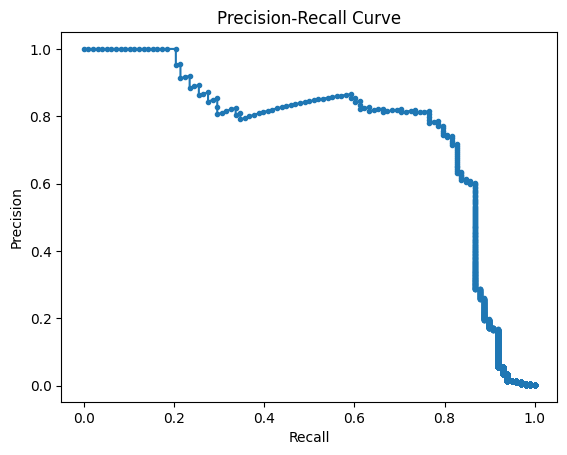

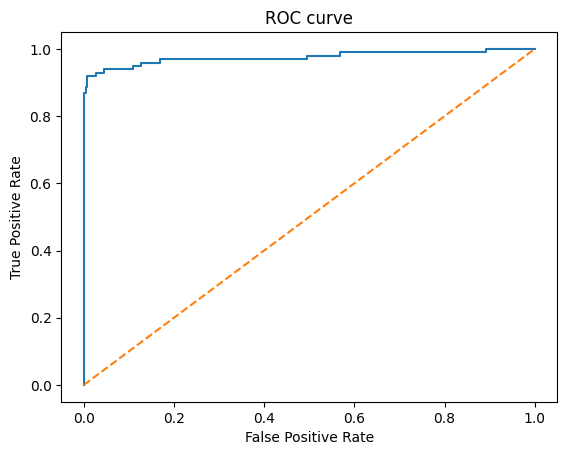

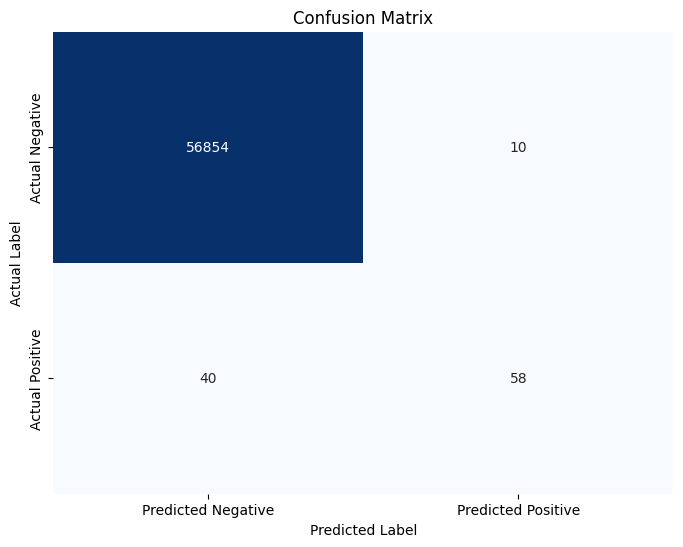

In [6]:
model_performance_results = display_record_performance(
    model_performance_results=model_performance_results,
    model_index=0, 
    model=model, 
    X_test=X_test, 
    y_test=y_test, 
    y_pred=y_pred, 
    y_pred_proba=y_pred_proba
)


## random forest

### train and test model

In [7]:
# save the model name into the results data frame
model_index = 1

model_performance_results.loc[model_index, 'model_name'] = 'random forest'

start_time = perf_counter()

# build a random forest model
# Prepare the data
X = cc.drop('class', axis=1)
y = cc['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

end_time = perf_counter()

# calculate the exectution time and save to the results data frame
execution_time = end_time - start_time
model_performance_results.loc[model_index, 'execution_time'] = execution_time

print(f"Execution time: {end_time - start_time} seconds")

Execution time: 192.0119646999956 seconds


### display results

,model_name,pr_auc,f1,roc_auc,R_squared,precision,recall,execution_time
0,logistic regression,0.757461,NaN,0.79583,0.999122,NaN,NaN,62.182699
1,random forest,0.868784,NaN,0.882627,0.999544,NaN,NaN,192.011965


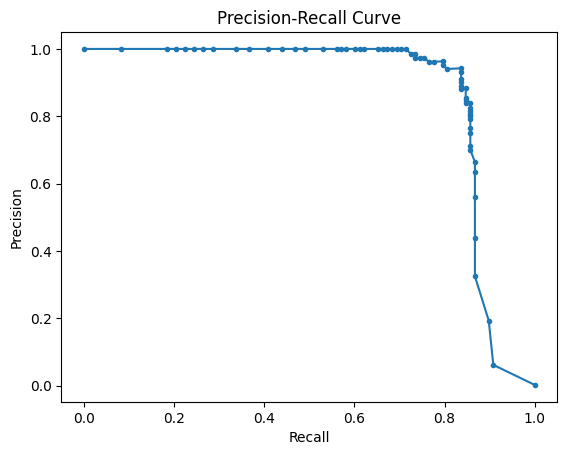

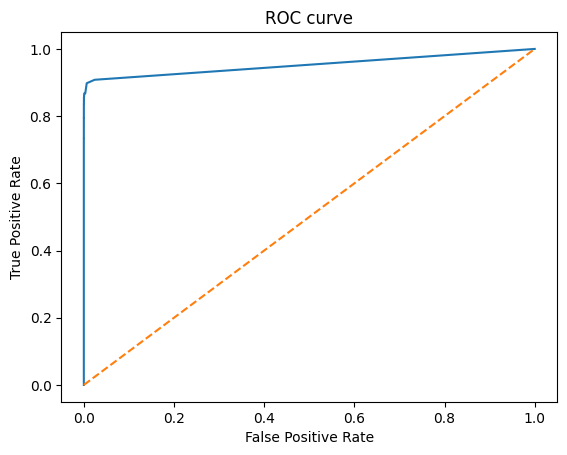

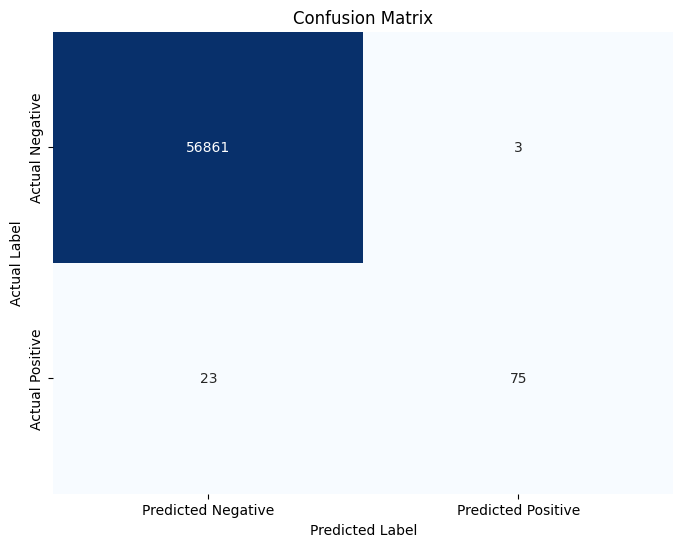

In [8]:
model_performance_results = display_record_performance(
    model_performance_results=model_performance_results,
    model_index=1, 
    model=model, 
    X_test=X_test, 
    y_test=y_test, 
    y_pred=y_pred, 
    y_pred_proba=y_pred_proba
)


## xgboost

### train and test model

In [9]:
# save the model name into the results data frame
model_index = 2

model_performance_results.loc[model_index, 'model_name'] = 'XGBoost'

start_time = perf_counter()

# Prepare the data
X = cc.drop('class', axis=1)
y = cc['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
model = xgb.XGBClassifier(eval_metric='mlogloss')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

end_time = perf_counter()

# calculate the exectution time and save to the results data frame
execution_time = end_time - start_time
model_performance_results.loc[model_index, 'execution_time'] = execution_time

print(f"Execution time: {end_time - start_time} seconds")

Execution time: 1.2157301000115694 seconds


,model_name,pr_auc,f1,roc_auc,R_squared,precision,recall,execution_time
0,logistic regression,0.757461,NaN,0.79583,0.999122,NaN,NaN,62.182699
1,random forest,0.868784,NaN,0.882627,0.999544,NaN,NaN,192.011965
2,XGBoost,0.880001,NaN,0.892831,0.999579,NaN,NaN,1.21573


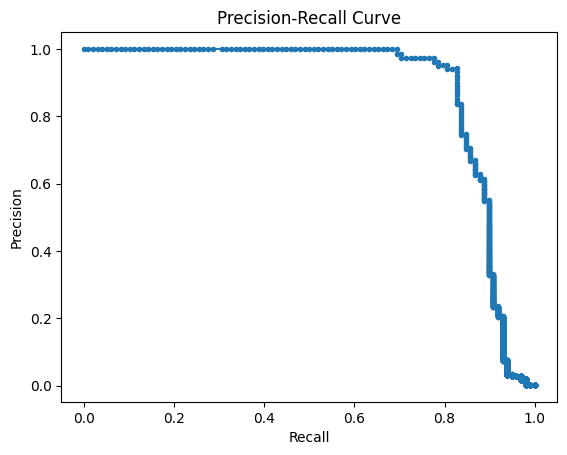

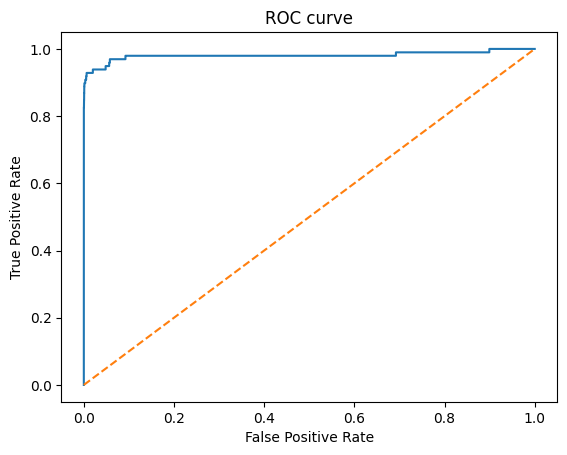

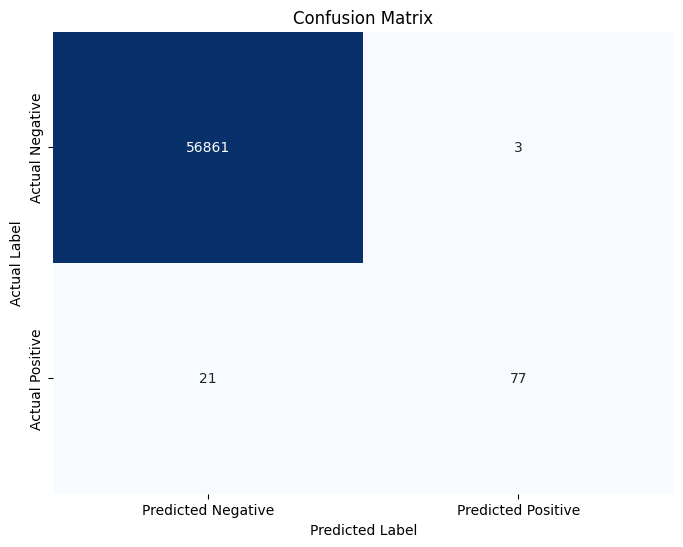

In [10]:
model_performance_results = display_record_performance(
    model_performance_results=model_performance_results,
    model_index=2, 
    model=model, 
    X_test=X_test, 
    y_test=y_test, 
    y_pred=y_pred, 
    y_pred_proba=y_pred_proba
)

## xgboost with SMOTE

### build and run model

In [11]:
# save the model name into the results data frame
model_index = 3

model_performance_results.loc[model_index, 'model_name'] = 'XGBoost w/SMOTE'

start_time = perf_counter()

# Prepare the data
X = cc.drop('class', axis=1).values  # Features
y = cc['class'].values  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the XGBoost model
model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

end_time = perf_counter()

# calculate the exectution time and save to the results data frame
execution_time = end_time - start_time
model_performance_results.loc[model_index, 'execution_time'] = execution_time

print(f"Execution time: {end_time - start_time} seconds")

Execution time: 2.580561499999021 seconds


,model_name,pr_auc,f1,roc_auc,R_squared,precision,recall,execution_time
0,logistic regression,0.757461,NaN,0.79583,0.999122,NaN,NaN,62.182699
1,random forest,0.868784,NaN,0.882627,0.999544,NaN,NaN,192.011965
2,XGBoost,0.880001,NaN,0.892831,0.999579,NaN,NaN,1.21573
3,XGBoost w/SMOTE,0.86998,NaN,0.918156,0.999298,NaN,NaN,2.580561


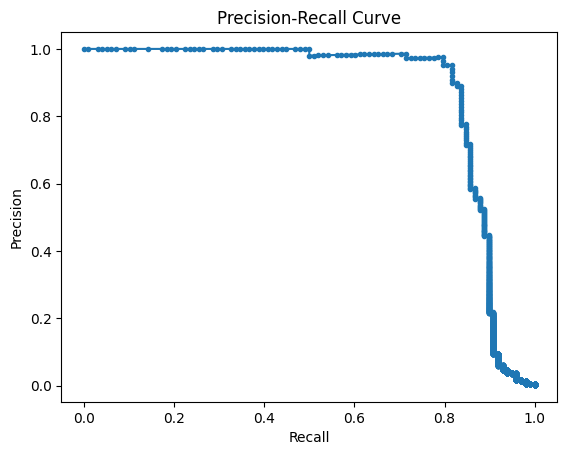

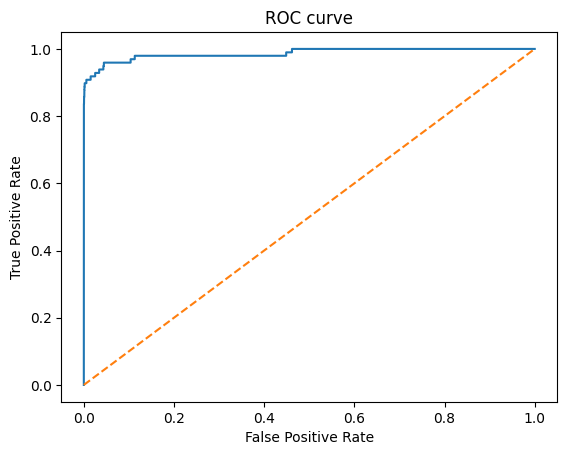

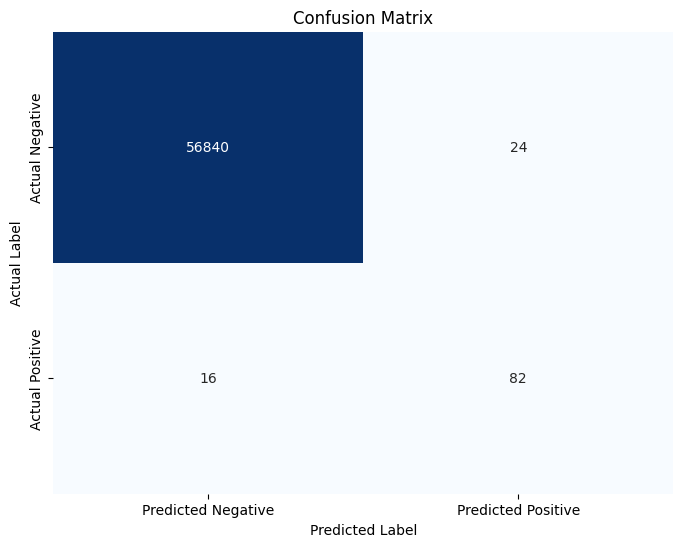

In [12]:
model_performance_results = display_record_performance(
    model_performance_results=model_performance_results,
    model_index=3, 
    model=model, 
    X_test=X_test, 
    y_test=y_test, 
    y_pred=y_pred, 
    y_pred_proba=y_pred_proba
)

## xgboost with scaled weights

### build and run model

In [13]:
# Save the model name into the results data frame
model_index = 4
model_performance_results.loc[model_index, 'model_name'] = 'XGBoost w/weighted classes'

start_time = perf_counter()

# Prepare the data
X = cc.drop('class', axis=1).values  # Features
y = cc['class'].values  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate scale_pos_weight
neg_count = sum(y_train == 0)
pos_count = sum(y_train == 1)
scale_pos_weight = neg_count / pos_count

# Train the XGBoost model with scale_pos_weight
model = xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

end_time = perf_counter()

# Calculate the execution time and save to the results data frame
execution_time = end_time - start_time
model_performance_results.loc[model_index, 'execution_time'] = execution_time

print(f"Execution time: {execution_time} seconds")

Execution time: 1.266274900001008 seconds


,model_name,pr_auc,f1,roc_auc,R_squared,precision,recall,execution_time
0,logistic regression,0.757461,NaN,0.79583,0.999122,NaN,NaN,62.182699
1,random forest,0.868784,NaN,0.882627,0.999544,NaN,NaN,192.011965
2,XGBoost,0.880001,NaN,0.892831,0.999579,NaN,NaN,1.21573
3,XGBoost w/SMOTE,0.86998,NaN,0.918156,0.999298,NaN,NaN,2.580561
4,XGBoost w/weighted classes,0.887722,NaN,0.913257,0.999684,NaN,NaN,1.266275


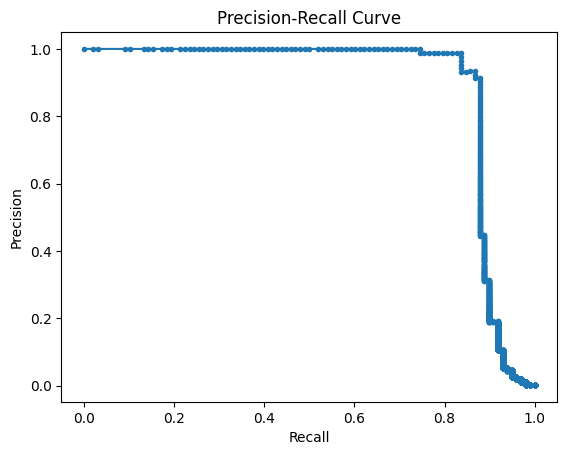

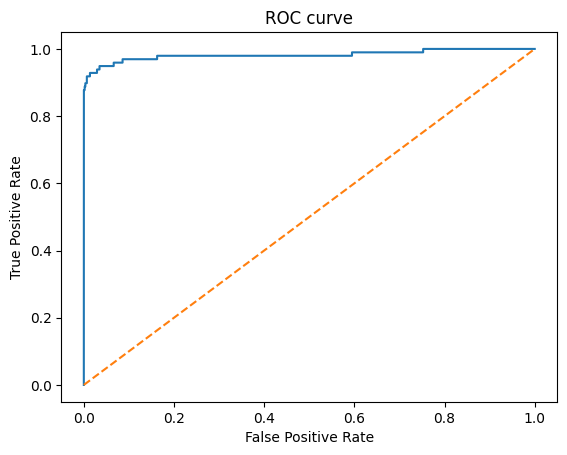

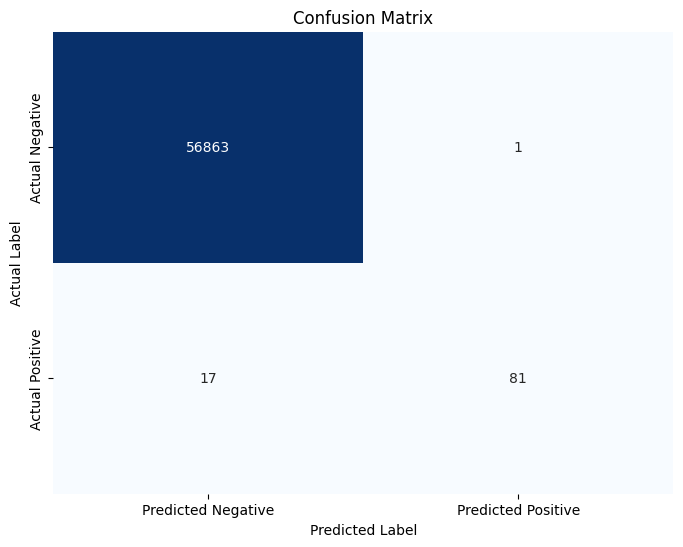

In [14]:
model_performance_results = display_record_performance(
    model_performance_results=model_performance_results,
    model_index=4, 
    model=model, 
    X_test=X_test, 
    y_test=y_test, 
    y_pred=y_pred, 
    y_pred_proba=y_pred_proba
)